In [2]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import torch
import cv2
import numpy as np
import torch
from rlepose.models import builder
from rlepose.utils.config import update_config
from rlepose.utils.valid_utils_lxd import calculate_error_distance_avg, calculate_RMSE, calculate_PCK, paint


cfg = update_config("../configs/256x192_res50_regress-flow_freihand.yaml")
device = torch.device('cuda')
# m = builder.build_sppe(cfg.MODEL, preset_cfg=cfg.DATA_PRESET)  # 根据cfg的配置信息构建模型

# m.load_state_dict(torch.load("/home/louxd/ldlib/res-loglikelihood-regression-master/weights/model_0918_233.pth", map_location='cpu'), 
#                   strict=True)  # 加载权重

model_path = './hand_landmarker.task'

base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)


with torch.no_grad():
    gt_val_dataset = builder.build_dataset(cfg.DATASET.VAL, preset_cfg=cfg.DATA_PRESET, train=False, heatmap2coord=cfg.TEST.HEATMAP2COORD)
    gt_val_sampler = torch.utils.data.distributed.DistributedSampler(
        gt_val_dataset, num_replicas=1, rank=0)

    gt_val_loader = torch.utils.data.DataLoader(
        gt_val_dataset, batch_size=16, shuffle=False, num_workers=20, drop_last=False, sampler=gt_val_sampler)
    
    
    rmse_list = []
    pck_pix = []
    pck_norm = []
    err_pix = []

    for index, (inps, labels) in enumerate(gt_val_loader):
        inps = inps.cuda(device)
        for k, _ in labels.items():
            if k == 'type':
                continue
            
            labels[k] = labels[k].cuda(device)

        kpts_gt = labels['target_uv'].cpu().numpy().reshape(-1, 21, 2) # size * 42

        # output = m(inps, labels)
        for i in range(len(inps)):
            imgi = inps[i].cpu().numpy()
            imgi = np.transpose(imgi, (1, 2, 0))
            imgi = (imgi + np.array([0.480, 0.457, 0.406], dtype=np.float32)) * np.array([255., 255., 255.], dtype=np.float32)
            imgi = cv2.cvtColor(imgi, cv2.COLOR_BGR2RGB) 
            imgi = imgi.astype(np.uint8)
            img_h, img_w, _ = imgi.shape
            # kpts_pre_i = np.array([(kpt + [0.5, 0.5]) * [img_w, img_h] for kpt in kpts_pre[i]])
            kpts_gt_i = np.array([(kpt + [0.5, 0.5]) * [img_w, img_h] for kpt in kpts_gt[i]])

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=imgi)
            detection_result = detector.detect(mp_image)
            hand_landmarks = detection_result.hand_landmarks

            if len(hand_landmarks) > 0:
                hand_lm = detection_result.hand_landmarks[0]
                pts_i = []

                for lm in hand_lm:
                    x = lm.x * img_w
                    y = lm.y * img_h
                    pts_i.append([x, y])

                imagei_pre = imgi.copy()
                pts_i = np.array(pts_i)
                _, rmse_i = calculate_RMSE(pts_i, kpts_gt_i)
                pck_pix_i, pck_norm_i = calculate_PCK(pts_i, kpts_gt_i)
                err_pix_i = calculate_error_distance_avg(pts_i, kpts_gt_i)
                rmse_list.append(rmse_i)
                pck_pix.append(pck_pix_i)
                pck_norm.append(pck_norm_i)
                err_pix.append(err_pix_i)
                print(index, i, err_pix_i)

    rmse = np.mean(rmse_list, axis=0)
    pck_pix = np.mean(pck_pix, axis=0)
    pck_norm = np.mean(pck_norm, axis=0)
    err_pix = np.mean(err_pix)




anno_xyz len： 3960
anno_K len： 3960
img list len： 3960
AUG OFF.
1 3 6.267716939486176
7 8 22.652749131862418
8 10 45.805269618146
13 2 8.416601935135962
14 3 14.529292478607958
15 6 10.505505657245372
20 3 10.253807148743544
23 12 13.048371701026625
33 5 127.32209764555074
33 15 7.604269971966341
35 1 46.576131532807516
35 6 7.894902995071455
55 3 69.5939465839232
63 7 10.15681446679648
65 14 7.327844724064045
67 8 11.276488745685034
73 15 11.131018836888176
81 0 8.54423505158953
82 9 107.87260479850936
85 15 14.31916006464953
90 7 8.867035132078522
94 12 8.079805166450218
97 0 7.534832109090287
98 9 4.834724296763765
100 15 48.927744690551684
113 6 99.95274214765803
125 8 9.25360519374087
128 12 11.665937931293966
129 6 5.506135700460231
132 3 11.1353747561076
138 9 8.756525056270979
140 15 15.896131412401619
148 12 77.04697111623524
154 0 18.41397330124631
161 3 6.368746343913086
164 1 75.05529550392222
165 0 10.68292940144939
166 13 17.28281882920275
168 1 101.14800128136544
182 11 

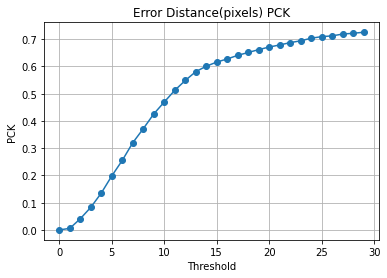

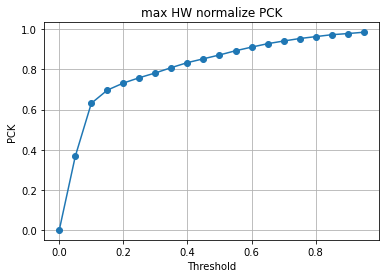

Pixels PCK:  [0.         0.00571429 0.04095238 0.08285714 0.1352381  0.19809524
 0.2552381  0.32       0.37142857 0.42571429 0.46952381 0.51238095
 0.54857143 0.58095238 0.60095238 0.61619048 0.62761905 0.64095238
 0.65142857 0.66190476 0.67142857 0.67904762 0.68761905 0.69428571
 0.70380952 0.70952381 0.71238095 0.71904762 0.72190476 0.72571429]
Norm PCK:  [0.         0.36761905 0.63142857 0.69714286 0.73238095 0.75904762
 0.78285714 0.80952381 0.83428571 0.85333333 0.87238095 0.89333333
 0.91142857 0.92857143 0.94190476 0.95428571 0.96380952 0.97333333
 0.97904762 0.98571429]
RMSE:  108.60327215891792
ERROR DISTANCE:  29.35182645708257


In [ ]:
import matplotlib.pyplot as plt
pixel_thresholds = np.arange(0, 30, 1)
norm_thresholds = np.arange(0, 1, 0.05)

average_precision = pck_pix

plt.plot(pixel_thresholds, average_precision, '-o')
plt.xlabel('Threshold')
plt.ylabel('PCK')
plt.title('Error Distance(pixels) PCK')
plt.grid(True)
plt.show()

norm_thresholds = np.arange(0, 1, 0.05)

average_precision = pck_norm


plt.plot(norm_thresholds, average_precision, '-o')
plt.xlabel('Threshold')
plt.ylabel('PCK')
plt.title('max HW normalize PCK')
plt.grid(True)
plt.show()

print("Pixels PCK: ", pck_pix)
print("Norm PCK: ", pck_norm)
print("RMSE: ", rmse)
print("ERROR DISTANCE: ", err_pix)


In [ ]:
detection_result.hand_landmarks[0][0]

NormalizedLandmark(x=0.8822426199913025, y=0.49387818574905396, z=8.636168900011398e-07, visibility=0.0, presence=0.0)